#  1. Kaggle competitions process
The data for this exercise is coming from the [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data).

## Training data exploration
We are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items in 10 different stores. To begin, we will explore the train data for this competition. For the faster performance, we will work with a subset of the train data containing only ~25% of it. Our initial goal is to read the input data and take the first look at it.

In [27]:
# Install packages https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
import sys
# !conda install --yes --prefix {sys.prefix} pandas
# !conda install --yes --prefix {sys.prefix} mkl-service
# !conda install --yes --prefix {sys.prefix} numpy
# !conda install --yes --prefix {sys.prefix} matplotlib
# !conda install --yes --prefix {sys.prefix} scikit-learn
# !conda install --yes --prefix {sys.prefix} xgboost

In [39]:
# Import packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [15]:
# Read train data
dir = 'data/store_item_demand_forecasting_challenge/'
train = pd.read_csv(dir + 'train.csv')

# Look at the shape of the data
train = train[int(0.75*train.shape[0]):] # take the latest 25% of the data
print('Train shape:', train.shape)

# Look at the head() of the data
print(train.head())

Train shape: (228250, 4)
              date  store  item  sales
684750  2013-01-01      6    38     31
684751  2013-01-02      6    38     20
684752  2013-01-03      6    38     37
684753  2013-01-04      6    38     41
684754  2013-01-05      6    38     50


Having looked at the train data, let's explore the test data in the "Store Item Demand Forecasting Challenge". Remember, that the test dataset generally contains one column less than the train one.

In [13]:
# Read the test data
test = pd.read_csv(dir + 'test.csv')

# Print train and test columns
print('Train columns:', train.columns.tolist())
print('Test columns:', test.columns.tolist())

Train columns: ['date', 'store', 'item', 'sales']
Test columns: ['id', 'date', 'store', 'item']


Let's have a look at the submission file to get the output format for the Kaggle competition.

In [16]:
# Read the sample submission file
sample_submission = pd.read_csv(dir + 'sample_submission.csv')

# Look at the head() of the sample submission
print(sample_submission.head())

   id  sales
0   0     52
1   1     52
2   2     52
3   3     52
4   4     52


The sample submission file consists of two columns: `id` of the observation and `sales` column for your predictions. Kaggle will evaluate your predictions on the true `sales` data for the corresponding `id`. So, it’s important to keep track of the predictions by `id` before submitting them.

To determine a problem type let's explore the target variable `sales` in the the train dataset.

<AxesSubplot:>

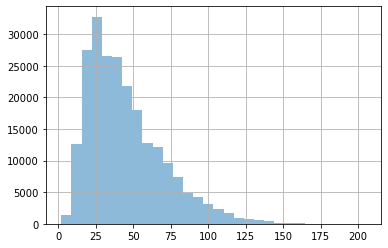

In [23]:
train.sales.hist(bins=30, alpha=0.5)

## Prepare a submission
The `sales` variable is continuous, so we're solving a regression problem. Now we're ready to build a model for a subsequent submission. For this exercise we will use `RandomForestRegressor` class from the `scikit-learn` library.

In [25]:
# Create a Random Forest object
rf = RandomForestRegressor()

# Train a model on the "store" and "item" features with "sales" as a target.
rf.fit(X=train[['store', 'item']], y=train['sales'])

# Get predictions for the test set
test['sales'] = rf.predict(test[['store', 'item']])

# Write test predictions using the sample_submission format (Note that sample submission has id and sales columns).
test[['id', 'sales']].to_csv('kaggle_submission.csv', index=False)

We've prepared our first Kaggle submission. Now, we could upload it to the Kaggle platform and see our score and current position on the Leaderboard. 

## Overfitting
Every Machine Learning method could potentially overfit. We will see it on this example with XGBoost. Firstly, let's train multiple XGBoost models with different sets of hyperparameters using XGBoost's learning API. The single hyperparameter we will change is:
- `max_depth` - maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.

In [38]:
# Create DMatrix on train data
dtrain = xgb.DMatrix(data=train[['store', 'item']],
                     label=train['sales'])

# Define xgboost parameters
params = {'objective': 'reg:squarederror',
          'max_depth': 2,
          'verbosity': 1}

# Train xgboost model
xg_depth_2 = xgb.train(params=params, dtrain=dtrain)


# Define xgboost parameters
params = {'objective': 'reg:squarederror',
          'max_depth': 8,
          'verbosity': 1}

# Train xgboost model
xg_depth_8 = xgb.train(params=params, dtrain=dtrain)

# Define xgboost parameters
params = {'objective': 'reg:squarederror',
          'max_depth': 15,
          'verbosity': 1}

# Train xgboost model
xg_depth_15 = xgb.train(params=params, dtrain=dtrain)

C:\Users\DmitriGazizulin\anaconda3\envs\intro-to-kaggle-competition\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Having trained 3 XGBoost models with different maximum depths, we will now evaluate their quality. For this purpose, we will measure the quality of each model on both the train data and the test data (assuming that the predictions from the Random Forest were correct). 

The goal of this exercise is to determine whether any of the models trained is overfitting. To measure the quality of the models we will use Mean Squared Error (MSE). It's available in sklearn.metrics as mean_squared_error() function that takes two arguments: true values and predicted values.

In [40]:
# Create DMatrix on test data
dtest = xgb.DMatrix(data=test[['store', 'item']])

# For each of 3 trained models
for model in [xg_depth_2, xg_depth_8, xg_depth_15]:
    # make predictions
    train_pred = model.predict(dtrain)
    test_pred = model.predict(dtest)
    
    # calculate metrics
    mse_train = mean_squared_error(train['sales'], train_pred)
    mse_test = mean_squared_error(test['sales'], test_pred)
    print('MSE Train: {:.3f}. MSE Test: {:.3f}'.format(mse_train, mse_test))

C:\Users\DmitriGazizulin\anaconda3\envs\intro-to-kaggle-competition\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


MSE Train: 328.703. MSE Test: 93.959
MSE Train: 194.991. MSE Test: 7.306
MSE Train: 194.580. MSE Test: 3.409


In these case we don't see an overfit since we don't have the real labels of the test set. However, this exercice was a good practice to conduct an overfit analysis.